# Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
import os 

# Functions

In [2]:
def get_cs_class(csv_path, target):
    return pd.read_csv(os.path.join(csv_path,target + "_class.txt"), header=None, delim_whitespace=True)
    
def get_cs_train_val(csv_path, target, class_=None):
    
    if not isinstance(class_, pd.DataFrame):
        class_ = get_cs_class(csv_path, target)
        
    cs_train = pd.read_csv(os.path.join(csv_path, target + "_train.csv"), header=None)
    cs_train["split"] = "train"
    
    cs_val = pd.read_csv(os.path.join(csv_path, target + "_val.csv"), header=None)
    cs_val["split"] = "val"
    
    cs = pd.concat([cs_train, cs_val], ignore_index=True)
    cs.columns = ["path", target + "_id", "cs-split-" + target]
        
    cs[target] = cs[target + "_id"].apply(lambda x: class_.loc[x][1])
    cs["style-from-path"] = cs["path"].apply(lambda x: x.split('/')[0])
    cs["artist-from-path"] = cs["path"].apply(lambda x: x.split('/')[1].split('_')[0])
    cs["title-from-path"] = cs["path"].apply(lambda x: x.split('/')[1].split('_')[1])
    
    return cs

def get_data(csv_path, image_path, rm_duplicate=True):
    
    cs_style = get_cs_train_val(csv_path, 'style')
    cs_genre = get_cs_train_val(csv_path, 'genre')
    cs_artist = get_cs_train_val(csv_path, 'artist')

    # There is one duplicata inside genre_train.csv / genre_test.csv
    # One image labelled with two genres
    if rm_duplicate:
        if not cs_genre[cs_genre["path"].duplicated(keep='first')].empty:
            cs_genre.drop(cs_genre[cs_genre["path"].duplicated(keep='first')].index, 
                          inplace=True)
             
    movement_list = [i for i in os.listdir(image_path) 
                     if i != '.DS_Store']
    
    movement = []
    artist = []
    image = []
    path = []
    
    for g in movement_list:
        files = os.listdir(os.path.join(image_path,g))
        movement.extend([g]*len(files))
        artist.extend(list(map(lambda x: x.split('_')[0], files)))
        image.extend(list(map(lambda x: x.split('_')[1], files)))
        path.extend(list(map(lambda x: g + '/' + x, files)))
    
    data = pd.DataFrame({"path": path, "movement": movement, "artist": artist, "image": image})
    
    data = data.merge(cs_genre[["path", "genre", "cs-split-genre"]], on="path",  how="outer")
    data = data.merge(cs_style[["path", "cs-split-style"]], on="path",  how="outer")
    data = data.merge(cs_artist[["path", "cs-split-artist"]], on="path",  how="outer")

    return data

# Get Data

In [3]:
csv_path = "../raw_data/wikiart"
image_path= "../raw_data/wikiart/wikiart"

In [4]:
data = get_data(csv_path, image_path)

In [5]:
data.head()

,path,movement,artist,image,genre,cs-split-genre,cs-split-style,cs-split-artist
0,Pointillism/henri-edmond-cross_chaine-des-maur...,Pointillism,henri-edmond-cross,chaine-des-maures-1907.jpg,landscape,train,train,NaN
1,Pointillism/theo-van-rysselberghe_fountain-at-...,Pointillism,theo-van-rysselberghe,fountain-at-san-souci-1903.jpg,cityscape,train,train,NaN
2,Pointillism/georges-seurat_the-away-samson-in-...,Pointillism,georges-seurat,the-away-samson-in-grandcamp-1885.jpg,landscape,train,train,NaN
3,Pointillism/theo-van-rysselberghe_portrait-of-...,Pointillism,theo-van-rysselberghe,portrait-of-madame-charles-maus-1890.jpg,portrait,train,train,NaN
4,Pointillism/jan-toorop_broek-in-waterland-1889...,Pointillism,jan-toorop,broek-in-waterland-1889.jpg,landscape,train,train,NaN


# Data Visualization

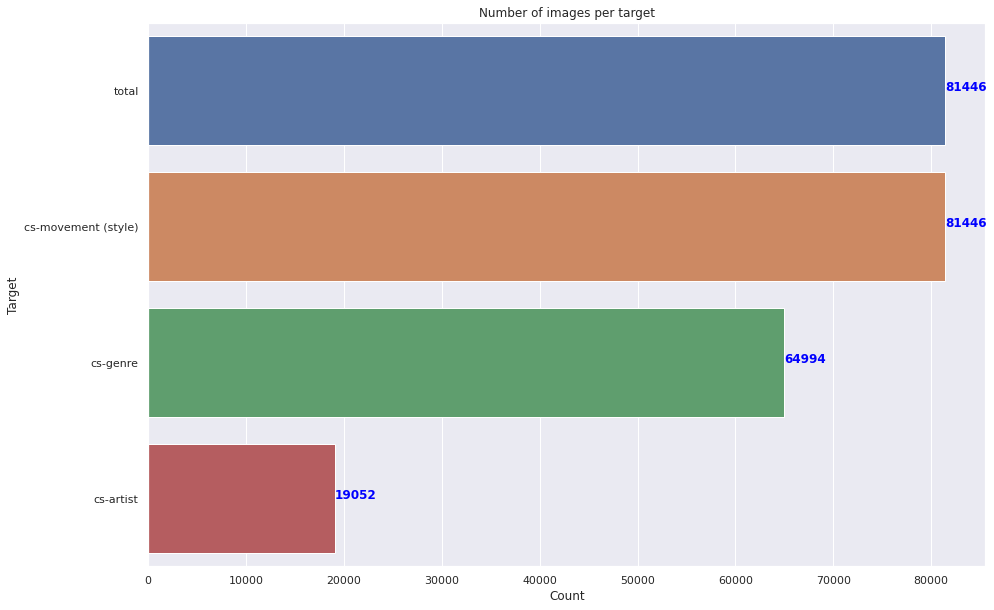

In [6]:
col = ['cs-split-artist','cs-split-genre','cs-split-style','path']

fig, ax = plt.subplots(1,1,figsize=(15,10))
sns.barplot(y=data[col].count().index, 
            x=data[col].count().values,
            order=data[col].count().sort_values(ascending=False).index,
            ax=ax);

for i, v in enumerate(data[col].count().sort_values(ascending=False).values):
    ax.text(v, i , str(v), color='blue', fontweight='bold')
    
ax.set_yticklabels(['total','cs-movement (style)','cs-genre','cs-artist']);
ax.set_title("Number of images per target");
ax.set_xlabel("Count");
ax.set_ylabel("Target");

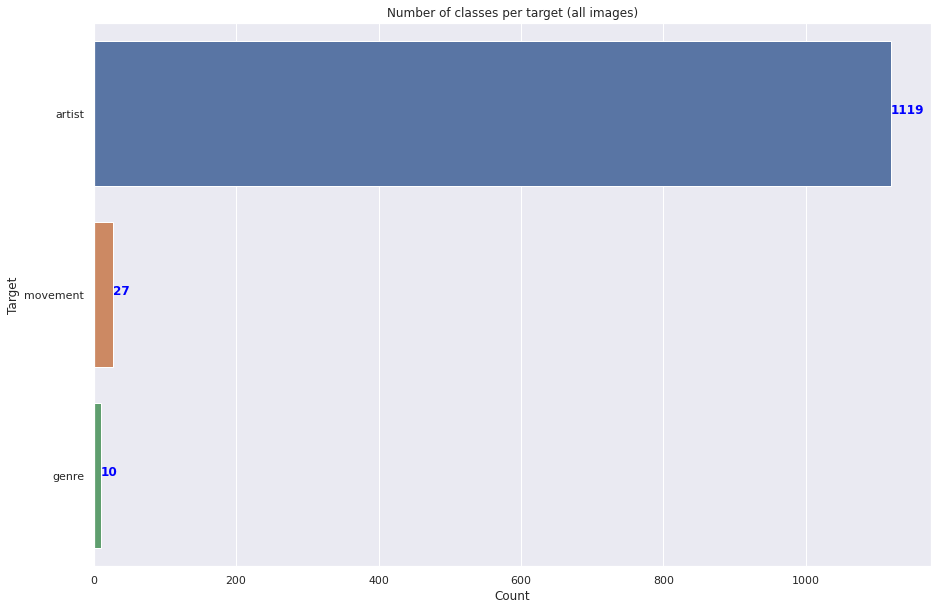

In [7]:
col = ['artist','genre','movement']

fig, ax = plt.subplots(1,1,figsize=(15,10))
sns.barplot(y=data[col].nunique().index, 
            x=data[col].nunique().values,
            order=data[col].nunique().sort_values(ascending=False).index,
            ax=ax);

for i, v in enumerate(data[col].nunique().sort_values(ascending=False).values):
    ax.text(v, i , str(v), color='blue', fontweight='bold')
    
ax.set_title("Number of classes per target (all images)");
ax.set_xlabel("Count");
ax.set_ylabel("Target");

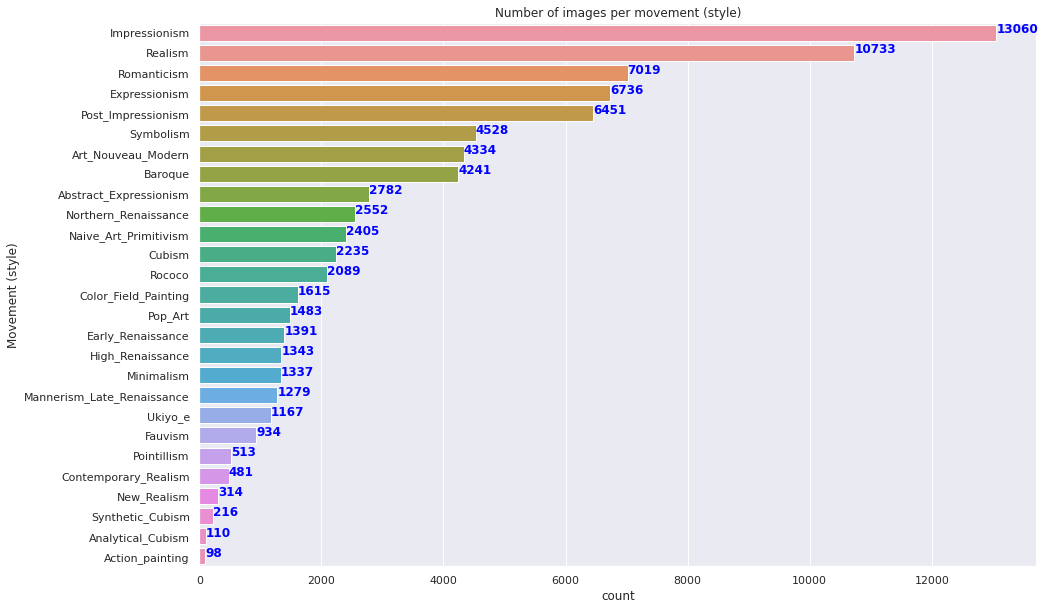

In [8]:
fig, ax = plt.subplots(1,1,figsize=(15,10));
sns.countplot(data=data, y="movement", 
              order = data['movement'].value_counts().index,
              ax=ax);

for i, v in enumerate(data["movement"].value_counts().values):
    ax.text(v, i , str(v), color='blue', fontweight='bold')
    
ax.set_title("Number of images per movement (style)");
ax.set_ylabel("Movement (style)");

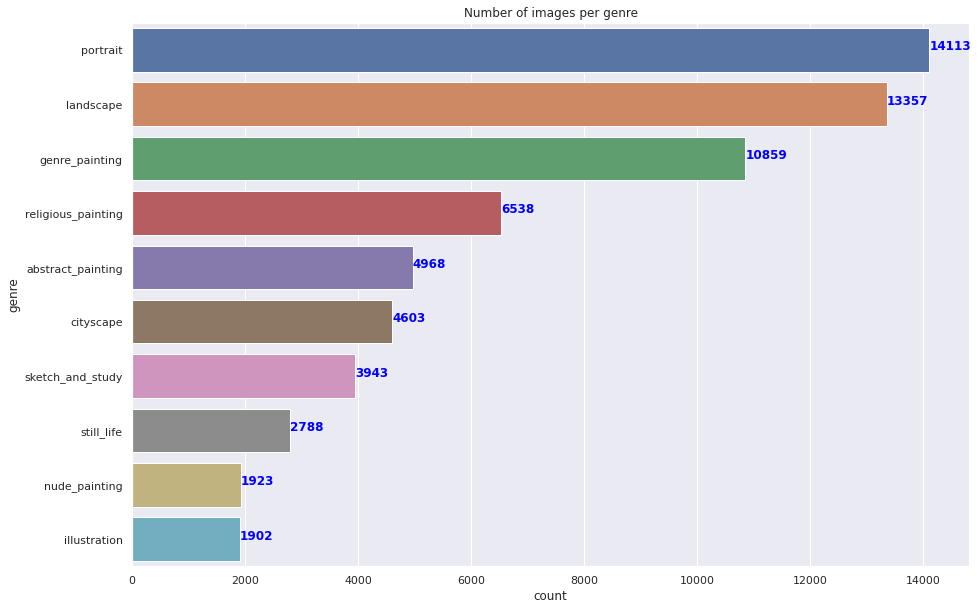

In [9]:
fig, ax = plt.subplots(1,1,figsize=(15,10));
sns.countplot(data=data, y="genre", 
              order = data['genre'].value_counts().index,
              ax=ax);

for i, v in enumerate(data["genre"].value_counts().values):
    ax.text(v, i , str(v), color='blue', fontweight='bold')
    
ax.set_title("Number of images per genre");

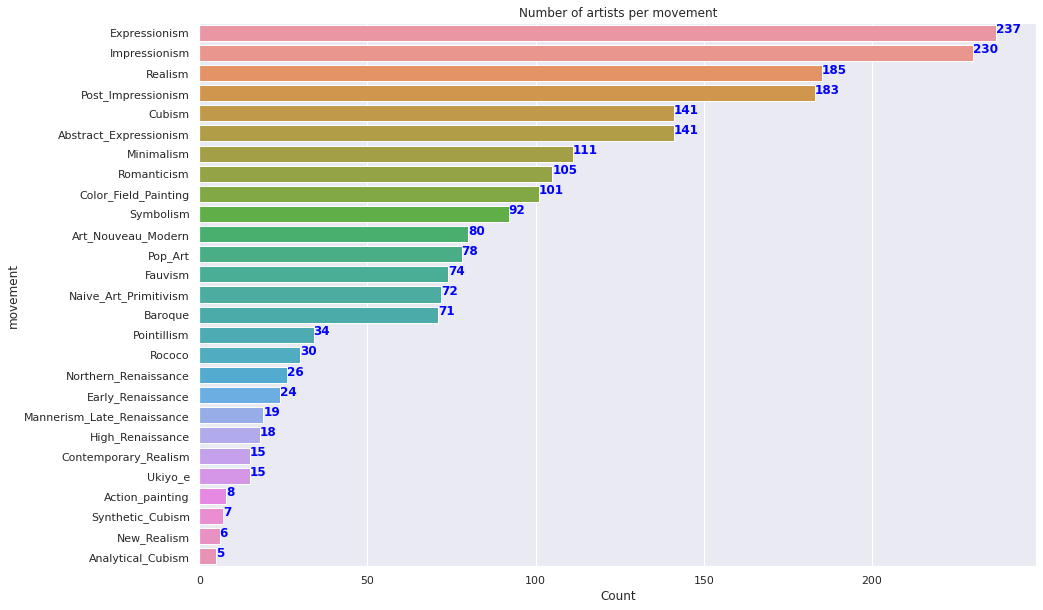

In [10]:
fig, ax = plt.subplots(1,1,figsize=(15,10));
sns.barplot(y=data.groupby("movement").artist.nunique().index, 
            x=data.groupby("movement").artist.nunique().values,
            order=data.groupby("movement").artist.nunique().sort_values(ascending=False).index,
            ax=ax);

for i, v in enumerate(data.groupby("movement").artist.nunique().sort_values(ascending=False).values):
    ax.text(v, i , str(v), color='blue', fontweight='bold')
    
ax.set_title("Number of artists per movement");
ax.set_xlabel("Count");